# Reward comparisons
This notebook compares different reward formulations such as
- Current reward 
- Minimalistic reward
- Reward curriculum
- Reward multiplication (requires normalization)

The overall goal is that the robot
- reach goal positions
- not hit obstacles
- staying in speed limits
- minimal time needed

From experiments the current reward struggles to move around bigger obstacles which might be due to the terms that try to keep the robot close to the reference trajectory. Other rewards should mitigate that.

## Reward fomulations
$$R_{current}=(l_{t} - l_{t-1}) - max(0, v_t-v_t^{ref}) - d_{path,t}^2*\Delta t  - R_{collision} + R_{goal}$$
$$R_{minimal}=(d_{goal,t} - d_{goal,t-1}) + R_{goal}$$
where $l$ is the traversed distance on the reference path, $v$ a velocity, $d$ a distance (either to path or goal).

### Curriculum
We want to test if a reward curriculum can help learning. For that, we first formulate the full reward function with all terms as
$$R_{all} = R_{minimal} + R_{speed,expectile} + R_{smooth}$$
where
$$R_{speed,expectile} = -w_{speed} * l_2^\tau(v-v_{ref})$$

with expectile being defined as 
$$
l_2^\tau = \begin{cases}
    \tau x^2 & \text{if } x>0 \\
    \tau x^2 & otherwise
\end{cases}
$$
and
$$R_{smooth} = -w_{smooth} * |a_{t}|$$
with $a_t$ being the action take (acceleration) at time $t$ (both linear and angular).  

The curriculum is then given by
$$R_{curriculum}=R_{minimal} + (s \ge 1) * R_{speed,expectile} + (s \ge 2) * R_{smooth} $$

For the curriculum, a stage is increased when a certain amount of steps have passed. Upon each reset the replay buffer is fully emptied and the critic parameters are reset

### Multiplication of terms
Another option is to multiply the terms in $R_{all}$ instead of summing them. In order for this to work, each term has to be positive. The reward function then becomes

$$R_{mult} = (1 + (d_{goal,t} - d_{goal,t-1})) * (1 + R_{speed,expectile}) * (1 + R_{smooth}) + R_{goal}$$




Rt = wg ⋅ goal_reward + wc⋅collision_penalty + wt⋅time_penalty + wd⋅distance_reward
with wg = 100, wc = -100, wt = -.1, wd = 1.

## Preliminaries

### Comparison of observation space
These comparisons are done using TD3 and minimalistic reward. Results are average over 3 seeds (10,100,200).

Changes:
- increase amount of beams (8->40)
- add robot and goal positions

In [2]:
new_obs_run_names = [
    "kilian/DRL-Traj-Planner/l5psua3k",
    "kilian/DRL-Traj-Planner/f35miish",
    "kilian/DRL-Traj-Planner/3z393gau",
]
old_obs_run_names = [
    "kilian/DRL-Traj-Planner/5z8ou7vh",
    "kilian/DRL-Traj-Planner/j4ihsq99",
    "kilian/DRL-Traj-Planner/22aq8sjn",
]

new_obs_non_convex = [
    "kilian/DRL-Traj-Planner/5tevww6f",
    "kilian/DRL-Traj-Planner/5djwqckb",
    "kilian/DRL-Traj-Planner/5cw6gzjo",
]
old_obs_non_convex = [
    "kilian/DRL-Traj-Planner/ie23ie3u",
    "kilian/DRL-Traj-Planner/9vu28rkv",
    "kilian/DRL-Traj-Planner/0fdo6418",
]

In [71]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

api = wandb.Api()

def extract_results(run_names, num_samples=50_000):
    results = defaultdict(list)
    
    for run_name in run_names:
        run = api.run(run_name)
        hist = run.history(samples=num_samples)
        success = hist["train/episode_success"].dropna().values
        ep_len = hist["train/episode_length"].dropna().values
        episode_reward = hist["train/episode_reward"].dropna().values
        results['success'].append(success)
        results['episode_length'].append(ep_len)
        results['episode_reward'].append(episode_reward)
        
    combined_results = {}
    for k, v in results.items():
        stacked_v = np.stack(v)
        combined_results[k] = stacked_v.mean(axis=0)
        combined_results[f"{k}_std"] = stacked_v.std(axis=0)

    return combined_results

In [4]:
dynamic_results = extract_results(new_obs_run_names)
old_obs_results = extract_results(old_obs_run_names)
non_convex_results = extract_results(new_obs_non_convex)
old_obs_non_convex_results = extract_results(old_obs_non_convex)

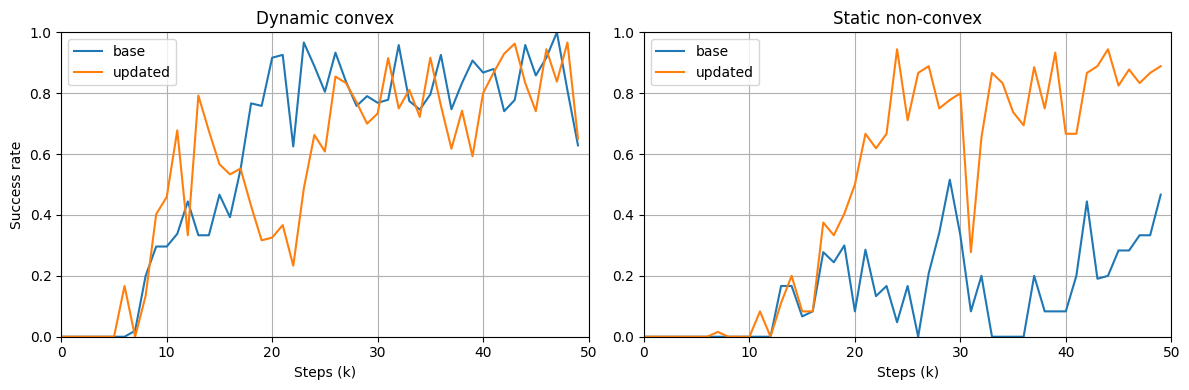

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

res1 = [old_obs_results, old_obs_non_convex_results]
res2 = [dynamic_results, non_convex_results]

for i, (r1, r2) in enumerate(zip(res1, res2)):
    axs[i].plot(r1['success'], label="base")
    axs[i].plot(r2['success'], label="updated")
    axs[i].grid()
    axs[i].set_xlim([0, 50])
    axs[i].set_ylim([0, 1])
    axs[i].legend()

axs[0].set_title("Dynamic convex")
axs[1].set_title("Static non-convex")
axs[0].set_xlabel("Steps (k)")
axs[1].set_xlabel("Steps (k)")
axs[0].set_ylabel("Success rate")
plt.tight_layout()
plt.show()

A reason for why the updated observation space is better for the static object might be that it can learn the position of the object as it does not change in the current setup. An extension might be to introduce a random factor in its position.
In the following, only the updated observation space will be used.

## Success comparions in dynamic convex map
For the following experiments the updates observation space is used and TD3. Results are average over 3 seeds (10,100,200).

In [5]:
dynamic_rw0_run_names = [
    "kilian/DRL-Traj-Planner/v4opblvu",
    "kilian/DRL-Traj-Planner/s5ltn5m1",
    "kilian/DRL-Traj-Planner/oomzywjh",
]
# dynamic_rw2_run_names = [
#     "kilian/DRL-Traj-Planner/tsp765ix",
#     "kilian/DRL-Traj-Planner/4ecjpp36",
#     "kilian/DRL-Traj-Planner/3lprlrm7",
# ]
dynamic_rw2_run_names = [
    "kilian/DRL-Traj-Planner/lb5b69ak",
    "kilian/DRL-Traj-Planner/xbmpqovz",
    "kilian/DRL-Traj-Planner/vo9xdg8m",
]
non_convex_rw0_run_names = [
    "kilian/DRL-Traj-Planner/g6k4ny0b",
    "kilian/DRL-Traj-Planner/fimx0sv1",
    "kilian/DRL-Traj-Planner/rikpd0s6",
]
non_convex_rw2_run_names = [
    "kilian/DRL-Traj-Planner/evby8gn7",
    "kilian/DRL-Traj-Planner/lwgxnd4z",
    "kilian/DRL-Traj-Planner/wnefd2jj",
]
corridor_run_names = [
    "kilian/DRL-Traj-Planner/7py06qdi",
    "kilian/DRL-Traj-Planner/w6wxluj5",
    "kilian/DRL-Traj-Planner/07bw4hik",
]
corridor_rw0_run_names = [
    "kilian/DRL-Traj-Planner/n4h481po",
    "kilian/DRL-Traj-Planner/9a90ulzp",
    "kilian/DRL-Traj-Planner/8dizwcw5",
]
corridor_rw2_run_names = [
    "kilian/DRL-Traj-Planner/qyo40zf1",
    "kilian/DRL-Traj-Planner/h7vxe4nr",
    "kilian/DRL-Traj-Planner/b80vomin",
]
# those are w/o jerk
corridor_rw3_run_names = [
    "kilian/DRL-Traj-Planner/lhrbk6c0",
    "kilian/DRL-Traj-Planner/wu2on46j",
    "kilian/DRL-Traj-Planner/qtuptv4y",
]

In [6]:
dynamic_rw0_results = extract_results(dynamic_rw0_run_names)
dynamic_rw2_results = extract_results(dynamic_rw2_run_names)
non_convex_rw0_results = extract_results(non_convex_rw0_run_names)
non_convex_rw2_results = extract_results(non_convex_rw2_run_names)
corridor_results = extract_results(corridor_run_names)
corridor_rw0_results = extract_results(corridor_rw0_run_names)
corridor_rw2_results = extract_results(corridor_rw2_run_names)

In [7]:
corridor_rw3_results = extract_results(corridor_rw3_run_names)

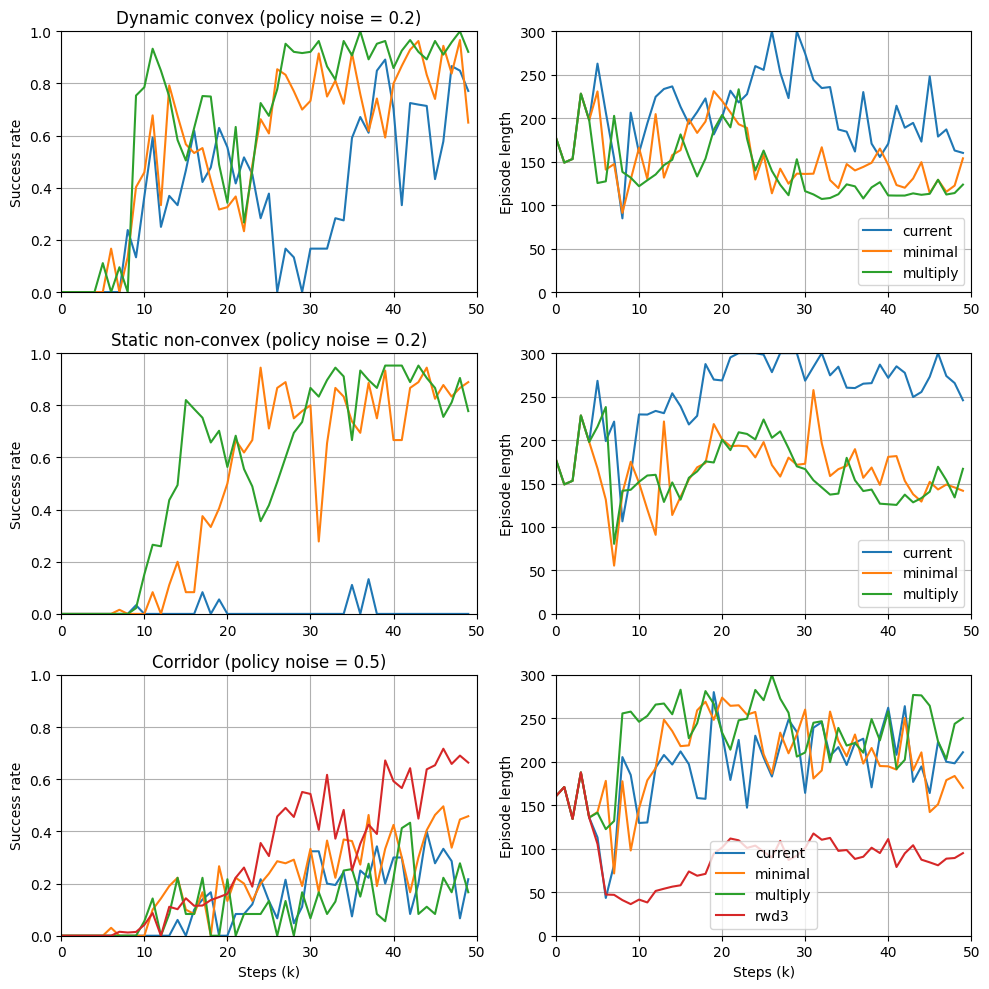

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

res1 = [dynamic_rw0_results, non_convex_rw0_results, corridor_rw0_results]
res2 = [dynamic_results, non_convex_results, corridor_results]
res3 = [dynamic_rw2_results, non_convex_rw2_results, corridor_rw2_results]

for i, (r1, r2, r3) in enumerate(zip(res1, res2, res3)):
    axs[i,0].plot(r1['success'], label="current")
    axs[i,0].plot(r2['success'], label="minimal")
    axs[i,0].plot(r3['success'], label="multiply")
    axs[i,1].plot(r1['episode_length'], label="current")
    axs[i,1].plot(r2['episode_length'], label="minimal")
    axs[i,1].plot(r3['episode_length'], label="multiply")
    
    if i == 2:
        axs[i,0].plot(corridor_rw3_results['success'], label="rwd3")
        axs[i,1].plot(corridor_rw3_results['episode_length'], label="rwd3")

    axs[i,0].grid()
    axs[i,1].grid()

    axs[i,0].set_xlim([0, 50])
    axs[i,1].set_xlim([0, 50])
    axs[i,0].set_ylim([0, 1])
    axs[i,1].set_ylim([0, 300])
    axs[i,1].legend()

axs[0,0].set_title("Dynamic convex (policy noise = 0.2)")
axs[1,0].set_title("Static non-convex (policy noise = 0.2)")
axs[2,0].set_title("Corridor (policy noise = 0.5)")
axs[2,0].set_xlabel("Steps (k)")
axs[2,1].set_xlabel("Steps (k)")
axs[0,0].set_ylabel("Success rate")
axs[1,0].set_ylabel("Success rate")
axs[2,0].set_ylabel("Success rate")
axs[0,1].set_ylabel("Episode length")
axs[1,1].set_ylabel("Episode length")
axs[2,1].set_ylabel("Episode length")
plt.tight_layout()
plt.show()

Used td3 implementation is not greatly different from sb3.
The path distance term might be the reason why the policy gets stuck in a local minimal of driving into the U shaped obstacle and does not easily find a way out.

For the last corridor experiment the policy noise was increase to 0.5 (from 0.2) and the noise_clip to 0.8 (from 0.5) as the environment seemed to need more exploration.

Note that increasing the policy noise from 0.2 to 0.4 in the static-non-convex case won't improve training with the current reward [see this run](https://wandb.ai/kilian/DRL-Traj-Planner/runs/hjfnos0q). Instead, it seems to increase the difference as the minimal reward seems to get better [see this run](https://wandb.ai/kilian/DRL-Traj-Planner/runs/tm4unhdn?nw=nwuserkilian).

In [ ]:
# curriculum for base + speed

dynamic_rw3_run_names = [
    "kilian/DRL-Traj-Planner/5b6r7zt9",
    "kilian/DRL-Traj-Planner/p94c8be2",
    "kilian/DRL-Traj-Planner/eu07ukt8",
]
dynamic_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/7o9by4zm",
    "kilian/DRL-Traj-Planner/zb14r65l",
    "kilian/DRL-Traj-Planner/1yls1nv4",
]

In [40]:
# dynamic_rw3_run_names = [
#     "kilian/DRL-Traj-Planner/czaclhrp",
#     "kilian/DRL-Traj-Planner/v97cbovc",
#     "kilian/DRL-Traj-Planner/0alkpfqb",
# ]
# dynamic_curriculum_run_names = [
#     "kilian/DRL-Traj-Planner/0wb30ydd",
#     "kilian/DRL-Traj-Planner/gziug81u",
#     "kilian/DRL-Traj-Planner/48hyvbyt",
# ]
dynamic_rw3_run_names = [
    "kilian/DRL-Traj-Planner/5b6r7zt9",
    "kilian/DRL-Traj-Planner/p94c8be2",
    "kilian/DRL-Traj-Planner/eu07ukt8",
]
dynamic_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/7o9by4zm",
    "kilian/DRL-Traj-Planner/zb14r65l",
    "kilian/DRL-Traj-Planner/1yls1nv4",
]

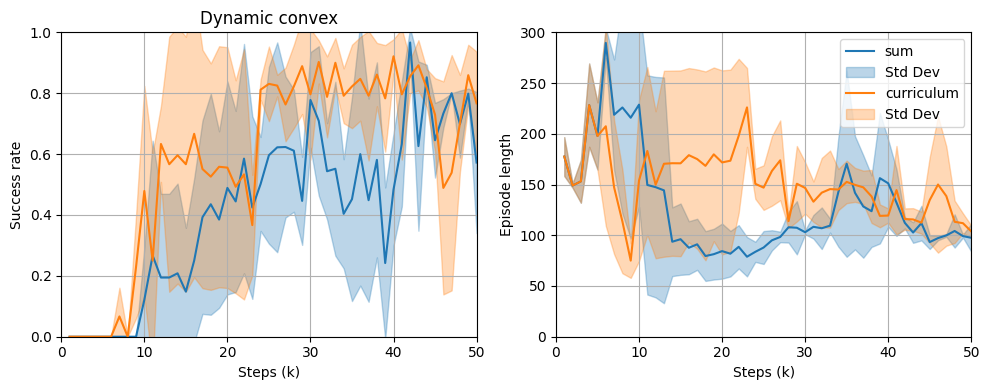

In [51]:
runs_1 = [dynamic_rw3_run_names]
runs_2 = [dynamic_curriculum_run_names]
labels = ["sum", "curriculum"]
plot_results([runs_1, runs_2], labels, num_samples=50_000, start_step=1_000)

DO I want to reset the critic at each curriculum stage update? [reset](https://wandb.ai/kilian/DRL-Traj-Planner/runs/4b0qcylk) vs [no reset](https://wandb.ai/kilian/DRL-Traj-Planner/runs/ae5u20x3?nw=nwuserkilian)

In [88]:
def plot_results(run_list, labels, num_samples=50_000, start_step=5_000):
    run_results_list = []
    for run in run_list:
        results = [extract_results(run_names, num_samples=num_samples) for run_names in run]
        run_results_list.append(results)

    nrows = len(run_results_list[0])
    fig, axs = plt.subplots(nrows=nrows,
                            ncols=3, figsize=(12, 4*nrows))
    axs = np.atleast_2d(axs)


    for i, result_row in enumerate(zip(*run_results_list)):
        for j, result in enumerate(result_row):
            x = np.linspace(start_step // 1000, num_samples // 1000, len(result['success']))
            y = result['success']
            y_std = result['success_std']
            axs[i,0].plot(x, y, label=labels[j])
            axs[i,0].fill_between(x, y - y_std, y + y_std, color=f'C{j}', alpha=0.3)
            y = result['episode_length']
            y_std = result['episode_length_std']
            axs[i,1].plot(x, y, label=labels[j])
            axs[i,1].fill_between(x, y - y_std, y + y_std, color=f'C{j}', alpha=0.3)
            y = result['episode_reward']
            y_std = result['episode_reward_std']
            axs[i,2].plot(x, y, label=labels[j])
            axs[i,2].fill_between(x, y - y_std, y + y_std, color=f'C{j}', alpha=0.3)

        axs[i,0].grid()
        axs[i,1].grid()
        axs[i,2].grid()

        axs[i,0].set_xlim([0, num_samples // 1000])
        axs[i,1].set_xlim([0, num_samples // 1000])
        axs[i,2].set_xlim([0, num_samples // 1000])
        axs[i,0].set_ylim([0, 1])
        axs[i,1].set_ylim([0, 300])
        axs[i,2].set_ylim([-70, 80])
        axs[i,1].legend()
    
    axs[0,1].set_title("Dynamic convex")
    axs[-1,0].set_xlabel("Steps (k)")
    axs[-1,1].set_xlabel("Steps (k)")
    axs[0,0].set_ylabel("Success rate")
    axs[0,1].set_ylabel("Episode length")
    axs[0,2].set_ylabel("Episode reward")
    if axs.shape[0] > 1:
        axs[1,1].set_title("Static non-convex")
        axs[1,0].set_ylabel("Success rate")
        axs[1,1].set_ylabel("Episode length")
        axs[1,2].set_ylabel("Episode reward")
    if axs.shape[0] > 2:
        axs[2,1].set_title("Corridor")
        axs[2,0].set_ylabel("Success rate")
        axs[2,1].set_ylabel("Episode length")
        axs[2,2].set_ylabel("Episode reward")

    plt.tight_layout()
    plt.show()

In [64]:
dynamic_rw3_run_names = [
    "kilian/DRL-Traj-Planner/5h4ec1tp",
    "kilian/DRL-Traj-Planner/tva0np5b",
    "kilian/DRL-Traj-Planner/wyj2d8rc",
]
dynamic_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/jgctdfha",
    "kilian/DRL-Traj-Planner/g35sy4zb",
    "kilian/DRL-Traj-Planner/4b0qcylk",
]
dynamic_curriculum_1stage_run_names = [
    "kilian/DRL-Traj-Planner/a5g8pulk",
    "kilian/DRL-Traj-Planner/xgh938wl",
    "kilian/DRL-Traj-Planner/re9b9bev",
]
static_rw3_run_names = [
    "kilian/DRL-Traj-Planner/mn0qg7my",
    "kilian/DRL-Traj-Planner/i28618oo",
    "kilian/DRL-Traj-Planner/5r49kno5",
]
static_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/04k2027b",
    "kilian/DRL-Traj-Planner/d916jyl8",
    "kilian/DRL-Traj-Planner/eacxsvdt",
]
static_curriculum_1stage_run_names = [
    "kilian/DRL-Traj-Planner/pqz40koi",
    "kilian/DRL-Traj-Planner/udqx094d",
    "kilian/DRL-Traj-Planner/adlycnwz",
]
corridor_rw3_run_names = [
    "kilian/DRL-Traj-Planner/ub8fq5qx",
    "kilian/DRL-Traj-Planner/3162extl",
    "kilian/DRL-Traj-Planner/vcmrfbih",
]
corridor_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/pm0fu9f0",
    "kilian/DRL-Traj-Planner/8edm15vd",
    "kilian/DRL-Traj-Planner/sbau12wg",
]
corridor_curriculum_1stage_run_names = [
    "kilian/DRL-Traj-Planner/i4yj102c",
    "kilian/DRL-Traj-Planner/drm8bn2i",
    "kilian/DRL-Traj-Planner/lzyua9nq",
]

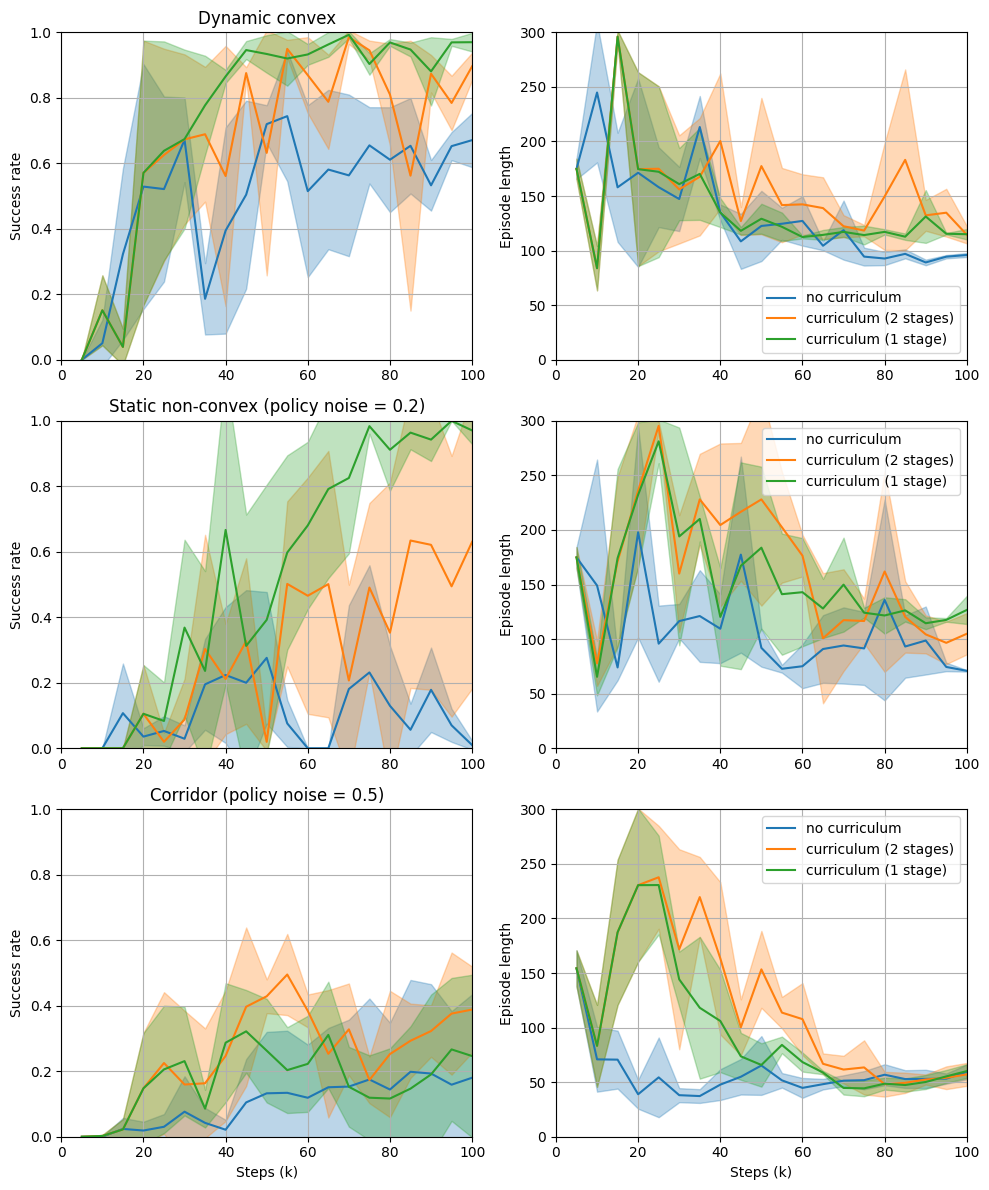

In [65]:
rw3_runs = [dynamic_rw3_run_names, static_rw3_run_names, corridor_rw3_run_names]
curriculum_runs = [dynamic_curriculum_run_names, static_curriculum_run_names, corridor_curriculum_run_names]
curriculum_1stage_runs = [dynamic_curriculum_1stage_run_names, static_curriculum_1stage_run_names,
                          corridor_curriculum_1stage_run_names]

plot_results([rw3_runs, curriculum_runs, curriculum_1stage_runs],
             ["no curriculum", "curriculum (2 stages)", "curriculum (1 stage)"], num_samples=100_000)

[Pretrained](https://wandb.ai/kilian/DRL-Traj-Planner/runs/0tnh9kks?nw=nwuserkilian) does not do better than [not pretrained](https://wandb.ai/kilian/DRL-Traj-Planner/runs/re9b9bev?nw=nwuserkilian) for some reason. Might want to reset actor before first training to make sure gradients flow properly.

Path 24_08_09_14_05_58_TD3 is good demonstration

### Smoothness term

In [ ]:
# How can I fix scenarios like the corridor?

In [ ]:
# TODO try resetting critic w/o curriculum

In [100]:
dynamic_sum_run_names = [
    "kilian/DRL-Traj-Planner/deg21k79",
    "kilian/DRL-Traj-Planner/90xz7qax",
    "kilian/DRL-Traj-Planner/0aal8xpv",
]
dynamic_sum_run_names_w_coll = [
    "kilian/DRL-Traj-Planner/iepbx86t",
    "kilian/DRL-Traj-Planner/poyq40ce",
    "kilian/DRL-Traj-Planner/inrs28jq",
]
dynamic_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/2z2vpvhk",
    "kilian/DRL-Traj-Planner/oqp39e1o",
    "kilian/DRL-Traj-Planner/3wslpk6g",
]
dynamic_curriculum_1stage_run_names = [
    "kilian/DRL-Traj-Planner/bfp2m9at",
    "kilian/DRL-Traj-Planner/rzdzh0bl",
    "kilian/DRL-Traj-Planner/f8z7rl5q",
]
dynamic_curriculum_1stage_coll_run_names = [
    "kilian/DRL-Traj-Planner/994i2fia",
    "kilian/DRL-Traj-Planner/jsaiu4a9",
    "kilian/DRL-Traj-Planner/cvzh3qaz",
]
dynamic_curriculum_no_reset_run_names = [
    "kilian/DRL-Traj-Planner/faul5kkx",
    "kilian/DRL-Traj-Planner/4urln6x3",
    "kilian/DRL-Traj-Planner/66tsouk5",
]

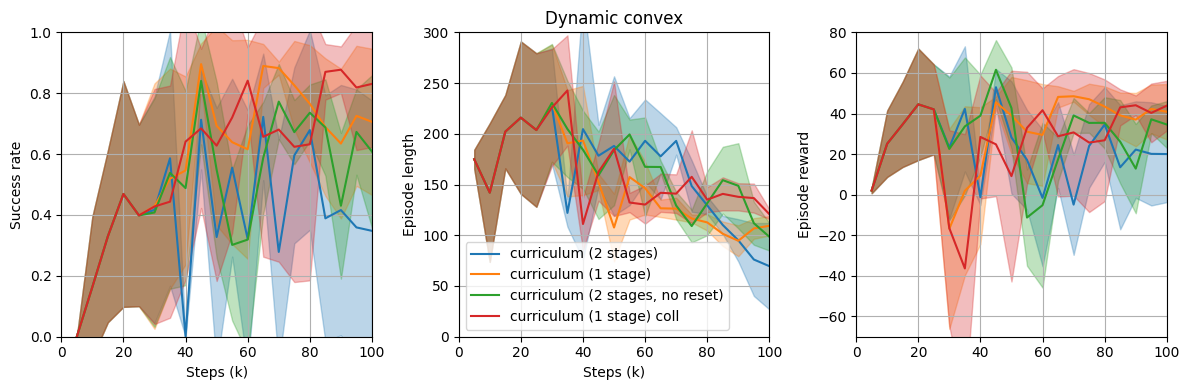

In [101]:
curriculum_runs = [dynamic_curriculum_run_names]
curriculum_1stage_runs = [dynamic_curriculum_1stage_run_names]
curriculum_runs_no_reset = [dynamic_curriculum_no_reset_run_names]
curriculum_1stage_coll_runs = [dynamic_curriculum_1stage_coll_run_names]

plot_results([ curriculum_runs, curriculum_1stage_runs,
              curriculum_runs_no_reset, curriculum_1stage_coll_runs],
             ["curriculum (2 stages)", "curriculum (1 stage)",
              "curriculum (2 stages, no reset)", "curriculum (1 stage) coll"], num_samples=100_000)

In [102]:
# those are TD3 100 k
dynamic_sum_2_run_names = [
    "kilian/DRL-Traj-Planner/06o5l1y6",
    "kilian/DRL-Traj-Planner/6cu3dyu0",
    "kilian/DRL-Traj-Planner/qmsdeyjq",
]

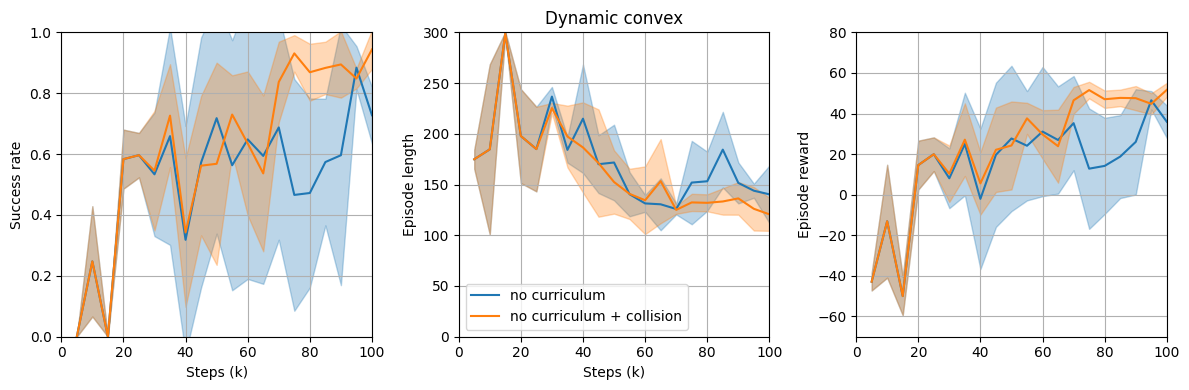

In [99]:
sum_runs = [dynamic_sum_run_names]
sum_runs_w_coll = [dynamic_sum_run_names_w_coll]
# sum_runs_w_coll_2 = [dynamic_sum_2_run_names]

plot_results([sum_runs, sum_runs_w_coll],
             ["no curriculum", "no curriculum + collision"], num_samples=100_000)

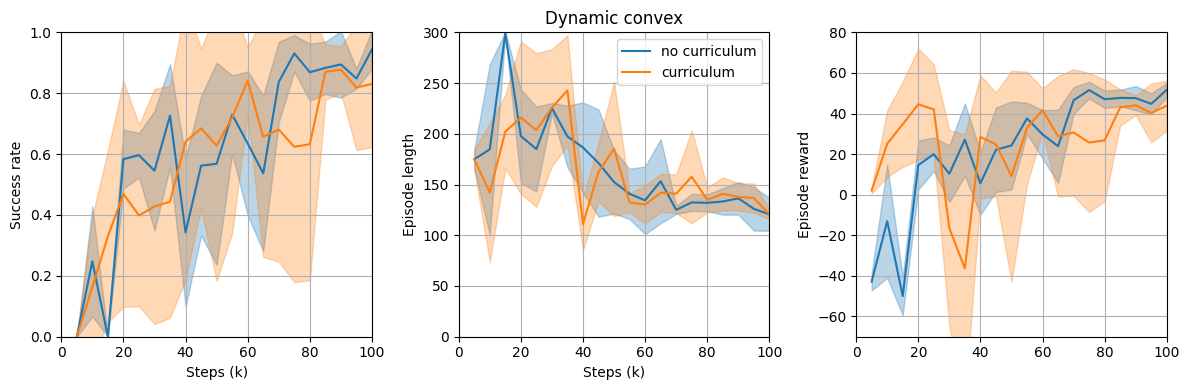

In [103]:
sum_runs_w_coll = [dynamic_sum_run_names_w_coll]
# curriculum_1stage_runs = [dynamic_curriculum_1stage_run_names]

plot_results([sum_runs_w_coll, curriculum_1stage_coll_runs],
             ["no curriculum", "curriculum"], num_samples=100_000)

### Short replay buffer (20k)
Here we don't reset anything and instead have a relatively short replay buffer.

In [95]:
# TD3 with 20k replay buffer and no resets of actor or replay buffer
dynamic_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/y6ugnyr1",
    "kilian/DRL-Traj-Planner/56y4jr6m",
    "kilian/DRL-Traj-Planner/vuo49pb3",
]
dynamic_sum_run_names = [
    "kilian/DRL-Traj-Planner/0bw7fbmd",
    "kilian/DRL-Traj-Planner/tabfzyf0",
    "kilian/DRL-Traj-Planner/xk501hwg",
]
static_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/vhpnv19p",
    "kilian/DRL-Traj-Planner/m51ci1jk",
    "kilian/DRL-Traj-Planner/yfj13lcc",
]
static_sum_run_names = [
    "kilian/DRL-Traj-Planner/bmcc8p3z",
    "kilian/DRL-Traj-Planner/s41v2upi",
    "kilian/DRL-Traj-Planner/l183uadj",
]

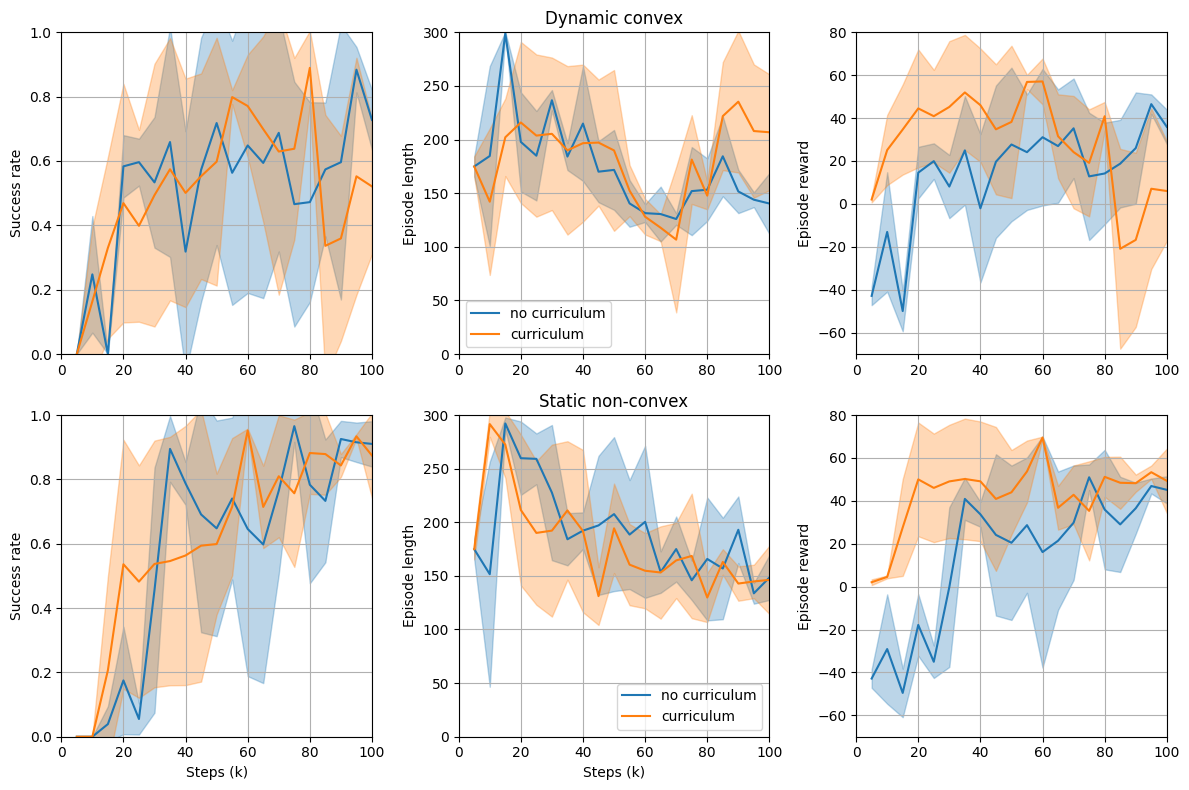

In [98]:
sum_runs = [dynamic_sum_run_names, static_sum_run_names]
curriculum_runs = [dynamic_curriculum_run_names, static_curriculum_run_names]

plot_results([sum_runs, curriculum_runs],
             ["no curriculum", "curriculum"], num_samples=100_000)

## Soft Actor-Critic

In [90]:
# SAC
dynamic_curriculum_run_names = [
    "kilian/DRL-Traj-Planner/vhpnv19p",
    "kilian/DRL-Traj-Planner/m51ci1jk",
    "kilian/DRL-Traj-Planner/yfj13lcc",
]
dynamic_sum_run_names = [
    "kilian/DRL-Traj-Planner/9ixcamws",
    "kilian/DRL-Traj-Planner/6ik3zmw3",
    "kilian/DRL-Traj-Planner/mfldjh52",
]
static_curriculum_run_names = [
    # "kilian/DRL-Traj-Planner/vhpnv19p",
    # "kilian/DRL-Traj-Planner/m51ci1jk",
    # "kilian/DRL-Traj-Planner/yfj13lcc",
]
static_sum_run_names = [
    # "kilian/DRL-Traj-Planner/bmcc8p3z",
    # "kilian/DRL-Traj-Planner/s41v2upi",
    # "kilian/DRL-Traj-Planner/l183uadj",
]

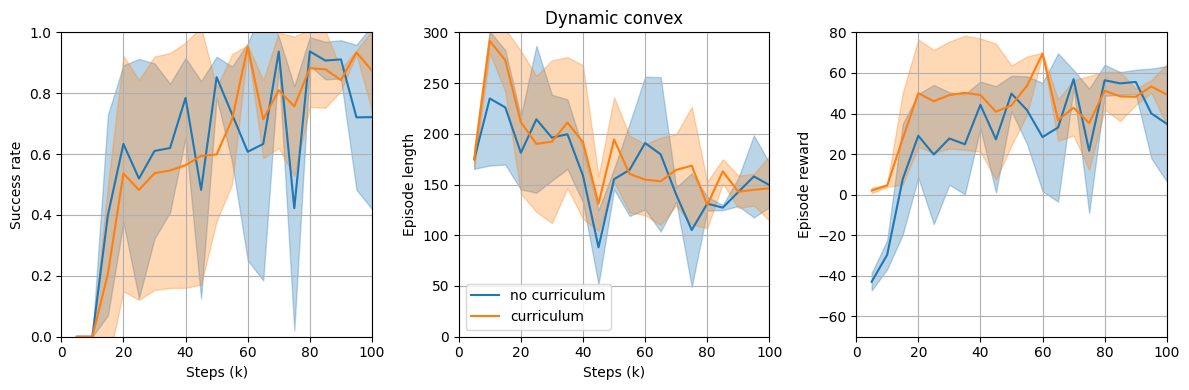

In [91]:
sum_runs = [dynamic_sum_run_names]
curriculum_runs = [dynamic_curriculum_run_names]

plot_results([sum_runs, curriculum_runs],
             ["no curriculum", "curriculum"], num_samples=100_000)

# Reward weight experiments
Find out more about weight ranges that are feasible with curriculum learning vs simply summing them. For curriculum, fully reset the replay buffer, rollout for 5k steps initially and then train every 1k steps. Keep q-function.